In [2]:
import os
from os.path import join as pj
import argparse
import sys
sys.path.append("modules")
import utils
import numpy as np
import torch as th
import scib
import scib.metrics as me
import anndata as ad
import scipy
import pandas as pd
import re
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from scipy.stats import pearsonr
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from operator import itemgetter
from collections import Counter
from tqdm import tqdm

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='new_query_cl')
parser.add_argument('--real_task', type=str, default='atlas_new')
parser.add_argument('--reference', type=str, default='atlas_new_no_neap')
parser.add_argument('--experiment', type=str, default='c_3')
parser.add_argument('--real_experiment', type=str, default='offline')
parser.add_argument('--model', type=str, default='default')
parser.add_argument('--init_model', type=str, default='')
parser.add_argument('--init_model_real', type=str, default='sp_latest')
parser.add_argument('--method', type=str, default='midas_embed')
o, _ = parser.parse_known_args()  # for python interactive
# o = parser.parse_args()

In [3]:
# Load latent variables of reference data
cfg_task = re.sub("_atlas|_generalize|_transfer|_ref_.*", "", o.task)
data_config = utils.gen_data_config(cfg_task)
data_config_ref = utils.gen_data_config(o.reference)
data_config_ref["raw_data_dirs"] += data_config["raw_data_dirs"]
data_config_ref["raw_data_frags"] += data_config["raw_data_frags"]
data_config_ref["combs"] = data_config["combs"]
data_config_ref["comb_ratios"] = data_config["comb_ratios"]
data_config_ref["s_joint"] = data_config["s_joint"]
data_config = utils.load_toml("configs/data.toml")[cfg_task]
for k, v in data_config.items():
    vars(o)[k] = v
model_config = utils.load_toml("configs/model.toml")["default"]
if o.model != "default":
    model_config.update(utils.load_toml("configs/model.toml")[o.model])
for k, v in model_config.items():
    vars(o)[k] = v
o.s_joint, o.combs, *_ = utils.gen_all_batch_ids(o.s_joint, o.combs)
o.pred_dir = pj("result", o.task, o.experiment, o.model, "predict", o.init_model)
pred = utils.load_predicted(o, group_by="subset")

c = [v["z"]["joint"][:, :o.dim_c] for v in pred.values()]
subset_num = 28
c_ref = np.concatenate(c[:subset_num], axis=0)
c_neap = np.concatenate(c[subset_num:], axis=0)
c_all = np.concatenate([c_neap, c_ref], axis=0)

o_real = copy.deepcopy(o)
o_real.task = o.real_task

o_real.pred_dir = pj("result", o_real.task, o.real_experiment, o.model, "predict", o.init_model_real)
pred_real = utils.load_predicted(o_real, group_by="subset")

# c_real = [v["z"]["joint"][:, :o_real.dim_c] for v in pred_real.values()]
# c_real = np.concatenate(c_real, axis=0)
c_neap_real = [v["z"]["joint"][:, :o_real.dim_c] for v in itemgetter(*[27, 28, 15, 16, 17, 18])(pred_real)]
c_neap_real = np.concatenate(c_neap_real, axis=0)
c_ref_real = [v["z"]["joint"][:, :o_real.dim_c] for v in itemgetter(*[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33])(pred_real)]
c_ref_real = np.concatenate(c_ref_real, axis=0)
c_all_real = np.concatenate([c_neap_real, c_ref_real], axis=0)
nbrs_real = NearestNeighbors(n_neighbors=15000, algorithm='ball_tree').fit(c_all_real)
distances_real, indices_real = nbrs_real.kneighbors(c_all_real)
indices_real

nbrs_all = NearestNeighbors(n_neighbors=15000, algorithm='ball_tree').fit(c_all)
distances_all, indices_all = nbrs_all.kneighbors(c_all)
indices_all

Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 29/29 [00:00<00:00, 295.58it/s]


Loading subset 1: z, joint


100%|██████████| 24/24 [00:00<00:00, 335.53it/s]


Loading subset 2: z, joint


100%|██████████| 40/40 [00:00<00:00, 317.00it/s]


Loading subset 3: z, joint


100%|██████████| 38/38 [00:00<00:00, 273.21it/s]


Loading subset 4: z, joint


100%|██████████| 29/29 [00:00<00:00, 329.39it/s]


Loading subset 5: z, joint


100%|██████████| 26/26 [00:00<00:00, 303.17it/s]


Loading subset 6: z, joint


100%|██████████| 27/27 [00:00<00:00, 413.69it/s]


Loading subset 7: z, joint


100%|██████████| 27/27 [00:00<00:00, 310.45it/s]


Loading subset 8: z, joint


100%|██████████| 28/28 [00:00<00:00, 310.15it/s]


Loading subset 9: z, joint


100%|██████████| 24/24 [00:00<00:00, 348.11it/s]


Loading subset 10: z, joint


100%|██████████| 29/29 [00:00<00:00, 93.78it/s]


Loading subset 11: z, joint


100%|██████████| 39/39 [00:00<00:00, 298.65it/s]


Loading subset 12: z, joint


100%|██████████| 38/38 [00:00<00:00, 285.64it/s]


Loading subset 13: z, joint


100%|██████████| 44/44 [00:00<00:00, 321.21it/s]


Loading subset 14: z, joint


100%|██████████| 11/11 [00:00<00:00, 330.26it/s]


Loading subset 15: z, joint


100%|██████████| 25/25 [00:00<00:00, 296.03it/s]


Loading subset 16: z, joint


100%|██████████| 24/24 [00:00<00:00, 304.19it/s]


Loading subset 17: z, joint


100%|██████████| 19/19 [00:00<00:00, 349.57it/s]


Loading subset 18: z, joint


100%|██████████| 21/21 [00:00<00:00, 289.29it/s]


Loading subset 19: z, joint


100%|██████████| 28/28 [00:00<00:00, 326.26it/s]


Loading subset 20: z, joint


100%|██████████| 24/24 [00:00<00:00, 344.31it/s]


Loading subset 21: z, joint


100%|██████████| 35/35 [00:00<00:00, 378.23it/s]


Loading subset 22: z, joint


100%|██████████| 35/35 [00:00<00:00, 352.36it/s]


Loading subset 23: z, joint


100%|██████████| 47/47 [00:00<00:00, 97.01it/s] 


Loading subset 24: z, joint


100%|██████████| 58/58 [00:00<00:00, 351.08it/s]


Loading subset 25: z, joint


100%|██████████| 39/39 [00:00<00:00, 318.82it/s]


Loading subset 26: z, joint


100%|██████████| 52/52 [00:00<00:00, 310.86it/s]


Loading subset 27: z, joint


100%|██████████| 28/28 [00:00<00:00, 361.94it/s]


Loading subset 28: z, joint


100%|██████████| 22/22 [00:00<00:00, 350.12it/s]


Loading subset 29: z, joint


100%|██████████| 20/20 [00:00<00:00, 334.44it/s]


Loading subset 30: z, joint


100%|██████████| 17/17 [00:00<00:00, 374.52it/s]


Loading subset 31: z, joint


100%|██████████| 21/21 [00:00<00:00, 274.67it/s]


Loading subset 32: z, joint


100%|██████████| 20/20 [00:00<00:00, 382.71it/s]


Loading subset 33: z, joint


100%|██████████| 15/15 [00:00<00:00, 278.48it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint
Converting subset 3: s, joint
Converting subset 3: z, joint
Converting subset 4: s, joint
Converting subset 4: z, joint
Converting subset 5: s, joint
Converting subset 5: z, joint
Converting subset 6: s, joint
Converting subset 6: z, joint
Converting subset 7: s, joint
Converting subset 7: z, joint
Converting subset 8: s, joint
Converting subset 8: z, joint
Converting subset 9: s, joint
Converting subset 9: z, joint
Converting subset 10: s, joint
Converting subset 10: z, joint
Converting subset 11: s, joint
Converting subset 11: z, joint
Converting subset 12: s, joint
Converting subset 12: z, joint
Converting subset 13: s, joint
Converting subset 13: z, joint
Converting subset 14: s, joint
Converting subset 14: z, joint
Converting subset 15: s, joint
Converting subset 15: z, joint
Conv

100%|██████████| 29/29 [00:00<00:00, 161.48it/s]


Loading subset 1: z, joint


100%|██████████| 24/24 [00:00<00:00, 163.44it/s]


Loading subset 2: z, joint


100%|██████████| 40/40 [00:00<00:00, 196.49it/s]


Loading subset 3: z, joint


100%|██████████| 38/38 [00:00<00:00, 55.77it/s]


Loading subset 4: z, joint


100%|██████████| 29/29 [00:00<00:00, 30.09it/s]


Loading subset 5: z, joint


100%|██████████| 26/26 [00:00<00:00, 71.53it/s]


Loading subset 6: z, joint


100%|██████████| 27/27 [00:00<00:00, 121.24it/s]


Loading subset 7: z, joint


100%|██████████| 27/27 [00:00<00:00, 69.53it/s]


Loading subset 8: z, joint


100%|██████████| 28/28 [00:00<00:00, 100.72it/s]


Loading subset 9: z, joint


100%|██████████| 24/24 [00:00<00:00, 222.23it/s]


Loading subset 10: z, joint


100%|██████████| 29/29 [00:00<00:00, 134.75it/s]


Loading subset 11: z, joint


100%|██████████| 39/39 [00:00<00:00, 158.22it/s]


Loading subset 12: z, joint


100%|██████████| 38/38 [00:00<00:00, 184.51it/s]


Loading subset 13: z, joint


100%|██████████| 44/44 [00:00<00:00, 147.20it/s]


Loading subset 14: z, joint


100%|██████████| 11/11 [00:00<00:00, 288.36it/s]


Loading subset 15: z, joint


100%|██████████| 17/17 [00:00<00:00, 40.22it/s]


Loading subset 16: z, joint


100%|██████████| 21/21 [00:00<00:00, 214.03it/s]


Loading subset 17: z, joint


100%|██████████| 20/20 [00:00<00:00, 101.00it/s]


Loading subset 18: z, joint


100%|██████████| 15/15 [00:00<00:00, 167.25it/s]


Loading subset 19: z, joint


100%|██████████| 25/25 [00:00<00:00, 111.59it/s]


Loading subset 20: z, joint


100%|██████████| 24/24 [00:00<00:00, 87.96it/s]


Loading subset 21: z, joint


100%|██████████| 19/19 [00:00<00:00, 87.29it/s] 


Loading subset 22: z, joint


100%|██████████| 21/21 [00:00<00:00, 97.23it/s]


Loading subset 23: z, joint


100%|██████████| 28/28 [00:00<00:00, 94.03it/s]


Loading subset 24: z, joint


100%|██████████| 24/24 [00:00<00:00, 97.30it/s] 


Loading subset 25: z, joint


100%|██████████| 35/35 [00:00<00:00, 77.86it/s]


Loading subset 26: z, joint


100%|██████████| 35/35 [00:00<00:00, 83.52it/s]


Loading subset 27: z, joint


100%|██████████| 22/22 [00:00<00:00, 150.45it/s]


Loading subset 28: z, joint


100%|██████████| 20/20 [00:00<00:00, 184.43it/s]


Loading subset 29: z, joint


100%|██████████| 47/47 [00:00<00:00, 79.32it/s]


Loading subset 30: z, joint


100%|██████████| 58/58 [00:01<00:00, 37.16it/s]


Loading subset 31: z, joint


100%|██████████| 39/39 [00:00<00:00, 81.49it/s]


Loading subset 32: z, joint


100%|██████████| 52/52 [00:00<00:00, 81.11it/s]


Loading subset 33: z, joint


100%|██████████| 28/28 [00:00<00:00, 115.59it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint
Converting subset 3: s, joint
Converting subset 3: z, joint
Converting subset 4: s, joint
Converting subset 4: z, joint
Converting subset 5: s, joint
Converting subset 5: z, joint
Converting subset 6: s, joint
Converting subset 6: z, joint
Converting subset 7: s, joint
Converting subset 7: z, joint
Converting subset 8: s, joint
Converting subset 8: z, joint
Converting subset 9: s, joint
Converting subset 9: z, joint
Converting subset 10: s, joint
Converting subset 10: z, joint
Converting subset 11: s, joint
Converting subset 11: z, joint
Converting subset 12: s, joint
Converting subset 12: z, joint
Converting subset 13: s, joint
Converting subset 13: z, joint
Converting subset 14: s, joint
Converting subset 14: z, joint
Converting subset 15: s, joint
Converting subset 15: z, joint
Conv

array([[     0,   2787,   7604, ...,   3363,  11683, 236125],
       [     1,  35759,    141, ..., 196125, 117358,   9227],
       [     2,    647,   6033, ..., 200623,  35587, 114121],
       ...,
       [252786, 252388, 252759, ...,   6641, 123427, 250521],
       [252787, 252586, 251768, ..., 150235, 203807,  48917],
       [252788, 252615, 252708, ...,  12890,  58560, 234586]])

In [4]:
neigh_size = [5, 10, 100, 1000, 2500, 5000, 10000, 15000]
overlap_num_list = []
sum_list = []
overlap_percent = []
for j in neigh_size:
    overlap_num = 0
    sum_num = 0
    for i in range(len(c_neap)):
        overlap_list = list(set(indices_all[i,1:j]) & set(indices_real[i,1:j]))
        overlap_num += len(overlap_list)
        sum_num += j-1
    overlap_num_list.append(overlap_num)
    sum_list.append(sum_num)
    overlap_percent.append(overlap_num/sum_num)

In [5]:
neigh_size = [5, 10, 100, 1000, 2500, 5000, 10000, 15000]
overlap_num_list = []
sum_list_all = []
overlap_percent_all = []
for j in tqdm(neigh_size):
    overlap_num = 0
    sum_num = 0
    for i in range(len(c_all)):
        overlap_list = list(set(indices_all[i,1:j]) & set(indices_real[i,1:j]))
        overlap_num += len(overlap_list)
        sum_num += j-1
    overlap_num_list.append(overlap_num)
    sum_list_all.append(sum_num)
    overlap_percent_all.append(overlap_num/sum_num)

100%|██████████| 8/8 [47:20<00:00, 355.11s/it]


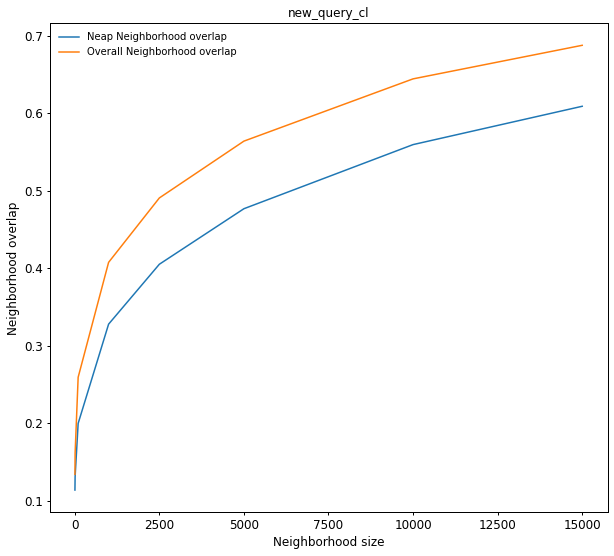

In [9]:
font = {'family':'times new roman', 
        'weight':'normal', 
        'size':15}
import matplotlib

fig = plt.figure(figsize=(10,9))
ax=plt.axes()
ax.spines['bottom'].set_linewidth('1.0')
ax.spines['left'].set_linewidth('1.0')
ax.spines['top'].set_linewidth('1.0')
ax.spines['right'].set_linewidth('1.0')
plt.tick_params(axis="both", which="major", width=1, length=3)
plt.plot(neigh_size, overlap_percent, label='Neap Neighborhood overlap', linewidth =1.5)
plt.plot(neigh_size, overlap_percent_all, label='Overall Neighborhood overlap', linewidth =1.5)

plt.xlabel('Neighborhood size', fontsize=12)
plt.ylabel('Neighborhood overlap', fontsize=12)
plt.xticks([0, 2500, 5000, 7500, 10000, 12500, 15000], fontsize=12)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], fontsize=12)
plt.title('new_query_cl', fontsize=12)
plt.legend(prop = {'size':10}, frameon=False)
matplotlib.rcParams['pdf.fonttype']=42
plt.savefig("./analysis/overlap/overlap_new_query_cl.png")
plt.savefig("./analysis/overlap/overlap_new_query_cl.pdf", format='pdf')
plt.show()

In [20]:
df = pd.DataFrame(overlap_percent)
print(df)
result_dir = pj("analysis", "overlap")
utils.mkdirs(result_dir, remove_old=False)
df.to_csv(pj(result_dir, "overlap_percent.csv"), index=False)

          0
0  0.113485
1  0.130584
2  0.199532
3  0.327609
4  0.404918
5  0.476601
6  0.559348
7  0.608822


In [21]:
df1 = pd.DataFrame(overlap_percent_all)
print(df1)
result_dir = pj("analysis", "overlap")
utils.mkdirs(result_dir, remove_old=False)
df1.to_csv(pj(result_dir, "overlap_percent_all.csv"), index=False)

          0
0  0.133741
1  0.161154
2  0.259064
3  0.407382
4  0.490494
5  0.563837
6  0.644187
7  0.687515
